<a href="https://colab.research.google.com/github/StephenJohnson-CardiffUni/Astro/blob/main/GalaxiesAssignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import numpy as np
from scipy.integrate import quad
from scipy import integrate
import matplotlib.pyplot as plt



In [11]:
initialMass = 1e11 #10^11 is 1e11 in this system
print(initialMass)

100000000000.0


In [18]:
from re import X
#Constants
SolarLumin = 3.828e26  # Solar luminosity in watts
SolarM = 2e30  # Solar mass in kilograms

# Assuming a lower limit of 0.5 solar masses and an upper limit of 100 solar masses
M_min = 0.5
M_max = 1000


def luminosity_func(M): #Takes mass in Kg, returns luminosity scalled by mass
  return SolarLumin*( (M/SolarM) **3.9)

def lifeTime_func(M): #Take Mass in Kg, returns lifetime on main sequence
  return 1e9 * (M/SolarM)**-2.5

def Mcrit(t): #Takes time in years, returns mass of stars whos life time is equal to this (the ones just dying in a galaxy t old)
  return ((10e9/t)**1/25)*SolarM

def IMFconst(MassTot):
  return MassTot / (integrate(X**-1.35,0.5,100))


In [17]:
print(IMFconst(1e9))

TypeError: 'module' object is not callable

Normalization constant A: 52959509317.161804
Total number of stars formed: 100000000000.0
Total luminosity of all stars formed: 8.443061695313631e-73


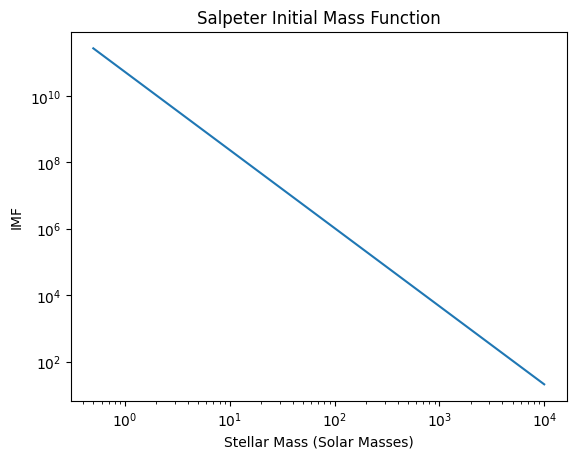

In [7]:
import numpy as np
from scipy.integrate import quad
import matplotlib.pyplot as plt

# Constants
M_cloud = 1e11  # Mass of the gas cloud in solar masses
t_collapse = 1e9  # Time it takes for the gas cloud to collapse in years
t_universe = 12e9  # Age of the universe in years
SFR = M_cloud / t_collapse  # Star Formation Rate (SFR) in solar masses per year

# Salpeter IMF parameters
alpha = 2.35  # Power-law exponent of the Salpeter IMF

# Solar luminosity in watts and solar mass in kilograms
SolarLumin = 3.828e26  # Solar luminosity in watts
SolarM = 2e30  # Solar mass in kilograms

# Define the Salpeter IMF function with normalization constant A
def salpeter_imf(M, A):
    return A * M**(-alpha)

# Integrate the Salpeter IMF to find the normalization constant A
def find_normalization_constant(M_min, M_max):
    return quad(salpeter_imf, M_min, M_max, args=(1,))[0]

# Assuming a lower limit of 0.5 solar masses and an upper limit of 100 solar masses
M_min = 0.5
M_max = 1000

# Calculate the normalization constant A
A = M_cloud / find_normalization_constant(M_min, M_max)

print("Normalization constant A:", A)

# Calculate the total number of stars formed
total_stars = A * find_normalization_constant(M_min, M_max)

print("Total number of stars formed:", total_stars)

# Define the luminosity function
def luminosity_function(M):
    return SolarLumin * (M / SolarM)**3.9

# Calculate the total luminosity of all stars formed
total_luminosity = 0
masses = np.linspace(M_min, M_max, num=1000)
imf_values = []
for mass in masses:
    luminosity = luminosity_function(mass)
    total_luminosity += luminosity * salpeter_imf(mass, A)  # Multiply by the IMF
    # Here, we multiply by the IMF value to account for the number of stars of this mass
    imf_values.append(salpeter_imf(mass, A))

print("Total luminosity of all stars formed:", total_luminosity)

# Plot the Initial Mass Function
plt.plot(masses, imf_values)
plt.xlabel('Stellar Mass (Solar Masses)')
plt.ylabel('IMF')
plt.title('Salpeter Initial Mass Function')
plt.xscale('log')
plt.yscale('log')
plt.show()

